This assignment is inspired by: 

- https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression
- https://www.kaggle.com/code/dansbecker/xgboost/notebook

In this assignment we will apply XGBoost Regression techniques to predict house prices, based on the famous Kaggle Dataset https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Step 1 is to download the dataset.

In [7]:
#=========================================================================
# load up the libraries
#=========================================================================
import pandas  as pd
import numpy   as np
import xgboost as xgb

#=========================================================================
# read in the data
#=========================================================================
import pandas as pd
import zipfile

# Set the path to your ZIP file
zip_path = r'C:/Users/alial/OneDrive/Desktop/LHL/applications of ml assignments/house-prices-advanced-regression-techniques.zip'

# Open and inspect the ZIP file
with zipfile.ZipFile(zip_path, 'r') as z:
    print(z.namelist())  # Lists files inside the ZIP to confirm the names

    # Read train.csv from the ZIP
    with z.open('train.csv') as f_train:
        train_data = pd.read_csv(f_train, index_col=0)

    # Read test.csv from the ZIP
    with z.open('test.csv') as f_test:
        test_data = pd.read_csv(f_test, index_col=0)

['data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']


### <center style="background-color:Gainsboro; width:60%;">Feature selection</center>
The purpose of feature selection, as the name suggests, is to only model the most pertinent and important features, thus reducing the computational overhead, and also to alleviate the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). The following are a number of notebooks covering techniques to achieve said goal, all of which use the House Prices data as an example:

* [Feature selection using the Boruta-SHAP package](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-the-boruta-shap-package)
* [Recursive Feature Elimination (RFE) example](https://www.kaggle.com/carlmcbrideellis/recursive-feature-elimination-rfe-example)
* [House Prices: Permutation Importance example](https://www.kaggle.com/carlmcbrideellis/house-prices-permutation-importance-example)
* [Feature importance using the LASSO](https://www.kaggle.com/carlmcbrideellis/feature-importance-using-the-lasso)

In this assignment, we shall use all of the numerical columns, and ignore the categorical features. To encode the categorical features one can use for example [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). 

Our first task is to do Feature Exploration and Selection. 

In [19]:
## Do your work here
# Basic structure
print(train_data.shape)
print(train_data.dtypes.value_counts())

# Preview the data
train_data.head()

(1460, 80)
object     43
int64      34
float64     3
Name: count, dtype: int64


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [20]:
# Step: drop columns with more than 30% missing values
missing_percent = train_data.isnull().mean() * 100
cols_to_drop = missing_percent[missing_percent > 30].index.tolist()

train_data_cleaned = train_data.drop(columns=cols_to_drop)
test_data_cleaned = test_data.drop(columns=cols_to_drop)


In [21]:
# Filter numerical columns from training data
numerical_cols = train_data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove the target column 'SalePrice' if it's in the list
if 'SalePrice' in numerical_cols:
    numerical_cols.remove('SalePrice')

# Now subset both datasets safely
X_train = train_data_cleaned[numerical_cols].copy()
X_test = test_data_cleaned[numerical_cols].copy()

# Target variable
y_train = train_data_cleaned['SalePrice']

In [22]:
# Numerical and categorical columns
num_features = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = train_data.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical: {len(num_features)}, Categorical: {len(cat_features)}")

Numerical: 37, Categorical: 43


In [23]:
# Check for missing values
missing = train_data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_percent = (missing / len(train_data)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percent': missing_percent})
missing_df.head(10)

,Missing Count,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


In [24]:
# Fill missing values with the median (can also use mean or other strategy)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())  # Use training medians

In [25]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1460, 36)
X_test shape: (1459, 36)


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

Training features shape: (1460, 36)
Numerical features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Missing values in X_train:
Series([], dtype: int64)


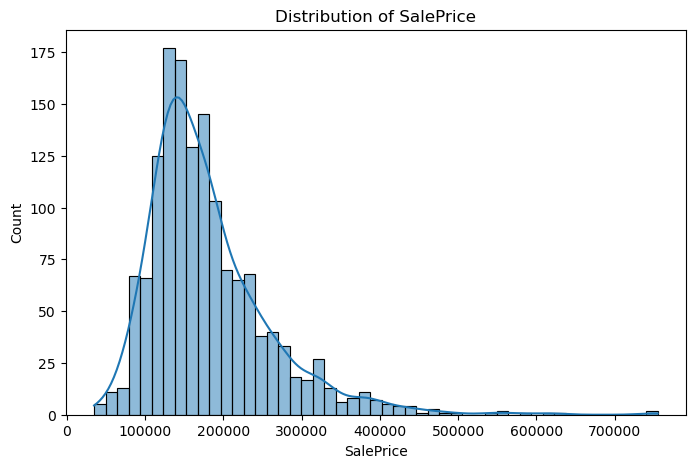

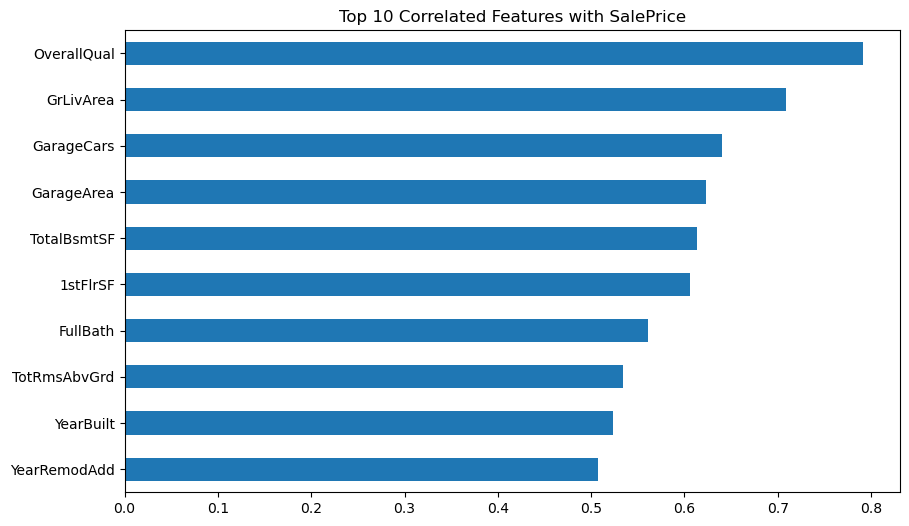

In [27]:
# === STEP 4: Exploratory Data Analysis (EDA) ===

# 4.1: Check shape and datatypes
print("Training features shape:", X_train.shape)
print("Numerical features:", numerical_cols)

# 4.2: Missing values
missing_train = X_train.isnull().sum().sort_values(ascending=False)
print("\nMissing values in X_train:")
print(missing_train[missing_train > 0])

# 4.3: Distribution of the target
plt.figure(figsize=(8, 5))
sns.histplot(y_train, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.show()

# 4.4: Correlation of features with target
Xy_corr = train_data_cleaned[numerical_cols + ['SalePrice']].corr()
corr_with_target = Xy_corr['SalePrice'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr_with_target[1:11].plot(kind='barh')  # Skip SalePrice itself
plt.title("Top 10 Correlated Features with SalePrice")
plt.gca().invert_yaxis()
plt.show()

### <center style="background-color:Gainsboro; width:60%;">Feature engineering</center>
As mentioned, one aspect of feature engineering is the creation of new features out of existing features. A simple example would be to create a new feature which is the sum of the number of bathrooms in the house:

In [28]:
for df in (X_train, X_test):
    df["n_bathrooms"] = df["BsmtFullBath"] + (df["BsmtHalfBath"]*0.5) + df["FullBath"] + (df["HalfBath"]*0.5)
    df["area_with_basement"]  = df["GrLivArea"] + df["TotalBsmtSF"]

Your next task is to apply some feature engineering to prepare for using the XGBoost Estimator to predict house prices.

In [29]:
## === Feature Engineering ===

# Apply the same feature engineering to both train and test
for df in (X_train, X_test):
    # Total number of bathrooms (full + 0.5 * half)
    df["n_bathrooms"] = df.get("BsmtFullBath", 0) + 0.5 * df.get("BsmtHalfBath", 0) \
                        + df.get("FullBath", 0) + 0.5 * df.get("HalfBath", 0)

    # Total area including basement
    df["area_with_basement"] = df.get("GrLivArea", 0) + df.get("TotalBsmtSF", 0)

    # Total porch area
    df["total_porch_sf"] = df.get("OpenPorchSF", 0) + df.get("EnclosedPorch", 0) \
                           + df.get("3SsnPorch", 0) + df.get("ScreenPorch", 0)

    # House age at the time it was sold
    df["house_age"] = df.get("YrSold", 0) - df.get("YearBuilt", 0)

    # Years since last remodel
    df["since_remodel"] = df.get("YrSold", 0) - df.get("YearRemodAdd", 0)

    # Total floors area (1st + 2nd floor)
    df["total_flr_sf"] = df.get("1stFlrSF", 0) + df.get("2ndFlrSF", 0)

    # Garage score (size * number of cars it holds)
    df["garage_score"] = df.get("GarageArea", 0) * df.get("GarageCars", 0)

    # Ratio of living area to lot area
    df["livLotRatio"] = df.get("GrLivArea", 0) / df.get("LotArea", 1)  # prevent division by zero

In [30]:
X_train[['n_bathrooms', 'area_with_basement', 'total_porch_sf', 'house_age']].head()

,n_bathrooms,area_with_basement,total_porch_sf,house_age
Id,,,,
1,3.5,2566,61,5
2,2.5,2524,0,31
3,3.5,2706,42,7
4,2.0,2473,307,91
5,3.5,3343,84,8


For more on this fascinating aspect may I recommend the free on-line book ["*Feature Engineering and Selection: A Practical Approach for Predictive Models*"](http://www.feat.engineering/) by Max Kuhn and Kjell Johnson.
### <center style="background-color:Gainsboro; width:60%;">XGBoost estimator</center>
Note that for this competition we use the RMSLE evaluation metric, rather than the default metric, which for regression is the RMSE. For more on the peculiarities of the RMSLE see the Appendix below.

In [31]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

Can you use grid search to find the optimal hyper parameters?

In [32]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np

In [35]:
def rmsle(y_true, y_pred):
    # Clip predictions to avoid log(negative) and negative values
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

# Wrap it with sklearn scorer (note: GridSearchCV tries to maximize the score, so set greater_is_better=False)
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
regressor = xgb.XGBRegressor(eval_metric='rmsle', use_label_encoder=False, random_state=42)

param_grid = {
    "max_depth": [4, 5],
    "n_estimators": [500, 600, 700],
    "learning_rate": [0.01, 0.015]
}

In [36]:
grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=5,                 # 5-fold cross-validation
    verbose=2,            # print progress
    n_jobs=-1             # use all cores
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\alial\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:13:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmsle', feature_types=None,
                                    feature_weights=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=N...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.015], 'max_depth': [4, 5],
                         'n_estimators': [500, 600, 700]},
             scoring=make_scorer(rmsle, greater_is_better=False, response_method='predict'),
             verbose=2)

In [37]:
print("Best RMSLE (negative):", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

Best RMSLE (negative): -0.13420437807968916
Best parameters: {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}


In [38]:
print("Best RMSLE:", -grid_search.best_score_)

Best RMSLE: 0.13420437807968916


Now, can you setup a XGBoost Regressor object using your hyperparameters and fit it?

In [40]:
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}


In [41]:
import xgboost as xgb

# Create the regressor with best hyperparameters
final_model = xgb.XGBRegressor(
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    eval_metric='rmsle',
    use_label_encoder=False,
    random_state=42
)

In [42]:
final_model.fit(X_train, y_train)

C:\Users\alial\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:14:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.015, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=None, num_parallel_tree=None, ...)

Finally, can you run it on your test set?

In [43]:
test_preds = final_model.predict(X_test)

# Ensure no negative predictions (RMSLE is undefined for negatives)
test_preds = np.maximum(0, test_preds)

In [44]:
submission = pd.DataFrame({
    'Id': X_test.index,
    'SalePrice': test_preds
})

submission.head()

,Id,SalePrice
0,1461,126417.992188
1,1462,159816.781250
2,1463,187279.046875
3,1464,187888.109375
4,1465,182184.656250


In [45]:
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


In [ ]:
Can you score your solution offline and see how it does?

In [47]:
import numpy as np

# Predict on training data
train_preds = final_model.predict(X_train)
train_preds = np.maximum(0, train_preds)  # clip negatives

# RMSLE function
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

score = rmsle(y_train, train_preds)
print(f"RMSLE on training data: {score:.5f}")

RMSLE on training data: 0.07952


Finally, use the below block to prepare your submission

In [56]:
output = pd.DataFrame({"Id":test_data.index, "SalePrice":predictions})
output.to_csv('submission.csv', index=False)

### <center style="background-color:Gainsboro; width:60%;">Feature importance</center>
Let us also take a very quick look at the feature importance too:

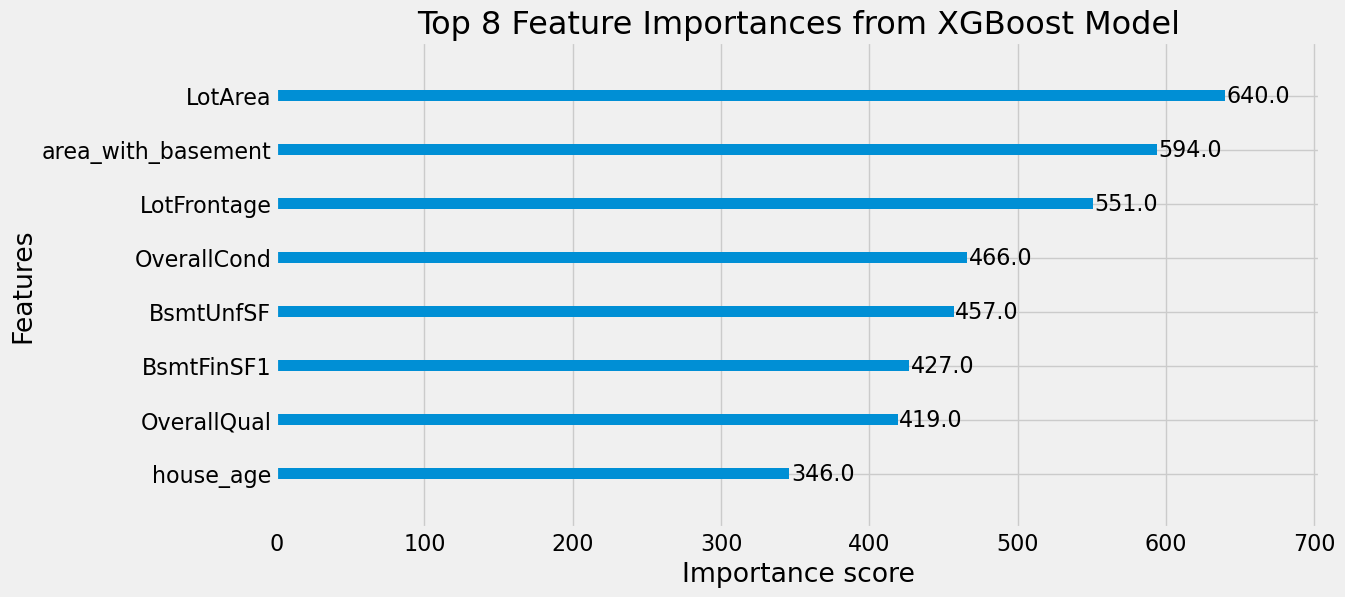

In [58]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12, 6))
plot_importance(final_model, max_num_features=8, ax=ax)
plt.title("Top 8 Feature Importances from XGBoost Model")
plt.show()

Where here the `F score` is a measure "*...based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees*." [1] 

Note that these importances are susceptible to small changes in the training data, and it is much better to make use of ["GPU accelerated SHAP values"](https://www.kaggle.com/carlmcbrideellis/gpu-accelerated-shap-values-jane-street-example), incorporated with version 1.3 of XGBoost.

Can you follow the above guide use SHAP values instead of F Score?

In [60]:
import shap
import matplotlib.pyplot as plt

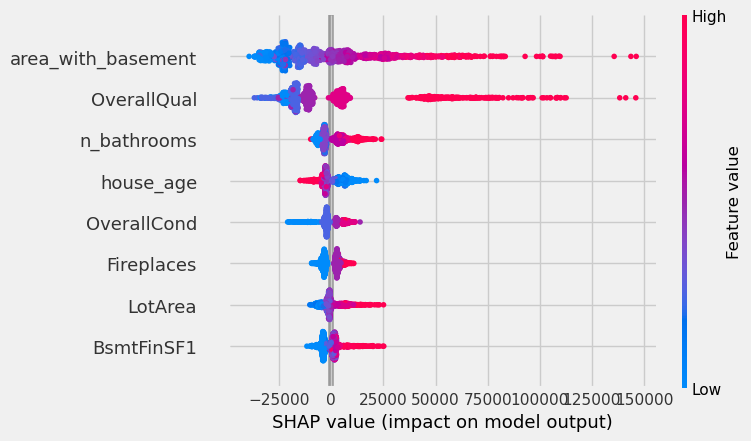

In [61]:
# Initialize the JavaScript visualization code for Jupyter notebooks
shap.initjs()

# Create SHAP explainer object for XGBoost model
explainer = shap.Explainer(final_model)

# Calculate SHAP values for the training data (or any dataset of interest)
shap_values = explainer(X_train)

# Summary plot (beeswarm) showing feature impact
shap.summary_plot(shap_values, X_train, max_display=8)

### <center style="background-color:Gainsboro; width:60%;">Appendix: The RMSLE evaluation metric</center>
From the competition [evaluation page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) we see that the metric we are using is the root mean squared logarithmic error (RMSLE), which is given by

$$ {\mathrm {RMSLE}}\,(y, \hat y) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $$

where $\hat{y}_i$ is the predicted value of the target for instance $i$, and $y_i$
is the actual value of the target for instance $i$.

It is important to note that, unlike the RMSE, the RMSLE is asymmetric; penalizing much more the underestimated predictions than the overestimated predictions. For example, say the correct value is $y_i = 1000$, then underestimating by 600 is almost twice as bad as overestimating by 600:

In [62]:
def RSLE(y_hat,y):
    return np.sqrt((np.log1p(y_hat) - np.log1p(y))**2)

print("The RMSLE score is %.3f" % RSLE( 400,1000) )
print("The RMSLE score is %.3f" % RSLE(1600,1000) )

The RMSLE score is 0.915
The RMSLE score is 0.470


The asymmetry arises because 

$$ \log (1 + \hat{y}_i) - \log (1 + y_i) =  \log \left( \frac{1 + \hat{y}_i}{1 + y_i} \right) $$

so we are essentially looking at ratios, rather than differences such as is the case of the RMSE. We can see the form that this asymmetry takes in the following plot, again using 1000 as our ground truth value:

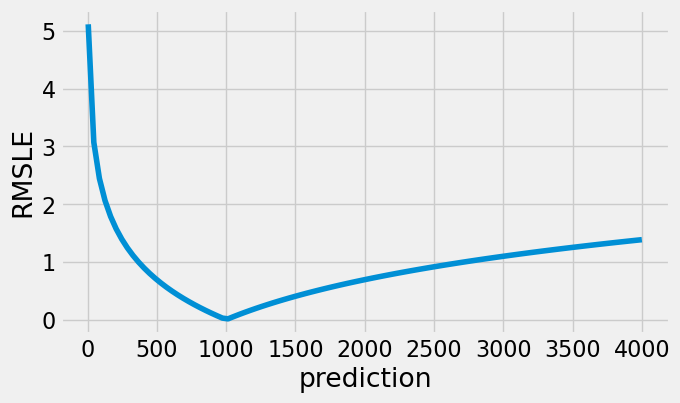

In [63]:
plt.rcParams["figure.figsize"] = (7, 4)
x = np.linspace(5,4000,100)
plt.plot(x, RSLE(x,1000))
plt.xlabel('prediction')
plt.ylabel('RMSLE')
plt.show()